Transfer Learning

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

#plt.gray()

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet"
)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
#tf.keras.applications.vgg19.preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!mkdir datasets

In [ ]:
!cp /gdrive/MyDrive/101_ObjectCategories.tar.gz ./datasets/101_ObjectCategories.tar.gz

In [ ]:
!tar -zxvf ./datasets/101_ObjectCategories.tar.gz

In [ ]:
data_dir = './101_ObjectCategories'
height = 224
width = 224

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(height, width),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x), y))

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(height, width),
    shuffle=False,
    seed=1,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x), y))

Found 9144 files belonging to 102 classes.
Using 7316 files for training.
Found 9144 files belonging to 102 classes.
Using 1828 files for validation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


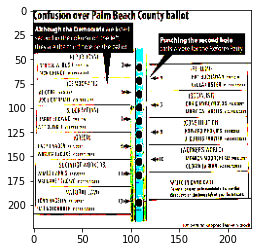

tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(102,), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
for x,y in train_dataset.take(1):
  plt.imshow(x[0])
  plt.show()

  print(y[0])
  print(tf.argmax(y[0]))

In [ ]:
def plot_history(h):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
vgg19.trainable = False

In [ ]:
for l in vgg19.layers:
  print(l.name, l.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_conv4 False
block5_pool False


In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
vgg19.outputs

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_pool')>]

In [ ]:
input_im = tf.keras.Input(shape=(height, width, 3))
x = vgg19(input_im)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(102, activation='softmax', kernel_initializer='he_uniform')(x)

good_model_adam = tf.keras.Model(input_im, x)
good_model_adam.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 102)               2559078   
                                                                 
Total params: 22,583,462
Trainable params: 2,559,078
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

good_model_adam.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics='accuracy')

h_good_adam = good_model_adam.fit(train_dataset, validation_data = val_dataset, epochs = 20)

Epoch 1/20
458/458 [==============================] - 40s 68ms/step - loss: 5.7268 - accuracy: 0.6771 - val_loss: 0.4880 - val_accuracy: 0.9508
Epoch 2/20
458/458 [==============================] - 35s 75ms/step - loss: 0.1543 - accuracy: 0.9773 - val_loss: 0.3746 - val_accuracy: 0.9710
Epoch 3/20
 60/458 [==>...........................] - ETA: 21s - loss: 0.0518 - accuracy: 0.9958

KeyboardInterrupt: ignored

In [ ]:
input_im = tf.keras.Input(shape=(height, width, 3))
x = vgg19(input_im)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(102, activation='softmax', kernel_initializer='he_uniform')(x)

good_model_2_adam = tf.keras.Model(input_im, x)
good_model_2_adam.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_2 (Dense)             (None, 102)               52326     
                                                                 
Total params: 20,076,710
Trainable params: 52,326
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

good_model_2_adam.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics='accuracy')

h_good_2_adam = good_model_2_adam.fit(train_dataset, validation_data = val_dataset, epochs = 20)

Epoch 1/20
458/458 [==============================] - 31s 66ms/step - loss: 64.5917 - accuracy: 0.1003 - val_loss: 51.7814 - val_accuracy: 0.0979
Epoch 2/20
458/458 [==============================] - 30s 66ms/step - loss: 36.1470 - accuracy: 0.2697 - val_loss: 32.5720 - val_accuracy: 0.2511
Epoch 3/20
458/458 [==============================] - 30s 66ms/step - loss: 23.5153 - accuracy: 0.4017 - val_loss: 21.5018 - val_accuracy: 0.3835
Epoch 4/20
458/458 [==============================] - 30s 66ms/step - loss: 16.3966 - accuracy: 0.5025 - val_loss: 15.4748 - val_accuracy: 0.4869
Epoch 5/20
458/458 [==============================] - 31s 66ms/step - loss: 12.0363 - accuracy: 0.5906 - val_loss: 11.6979 - val_accuracy: 0.5722
Epoch 6/20
458/458 [==============================] - 30s 66ms/step - loss: 9.1691 - accuracy: 0.6546 - val_loss: 9.0900 - val_accuracy: 0.6389
Epoch 7/20
458/458 [==============================] - 35s 76ms/step - loss: 7.1792 - accuracy: 0.7035 - val_loss: 7.3609 - val